# Reports
1. Inputs: data from kaggle and business problem
2. Outputs: results conslusions and request API

# 1.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

import time

tempo_agora = time.time()

###### 1.1 Helper Functions

In [2]:
# buscar outliers pelo método de Tukey
def buscar_outliers(df, col):
    primeiro_quartil = df[col].quantile(0.25)
    terceiro_quartil = df[col].quantile(0.75)
    range_ = terceiro_quartil - primeiro_quartil
    salto = range_ * 1.5
    limite_inferior = primeiro_quartil - salto
    limite_superior = terceiro_quartil + salto
    outliers_indices = df[(df[col]<limite_inferior)|(df[col]>limite_superior)].index
    return outliers_indices, limite_inferior, limite_superior

# estatística descritiva de primeira e segunda ordem
def desc_stats(df, col):
    print(f'Dados da feature: {col}\n')
    print(f'Máximo (max): {df[col].max()}')
    print(f'Mínimo (min): {df[col].min()}')
    print(f'Range (range): {df[col].max()-df[col].min()}')
    print(f'Média (mean): {df[col].mean()}')
    print(f'Mediana (median): {df[col].median()}')
    print(f'Desvio padrão (standard deviation): {df[col].std()}')
    print(f'Curtose (kurtosis): {df[col].kurtosis()}')
    print(f'Assimetria (skew): {df[col].skew()}')

###### 1.2 Loading Dataset

In [3]:
df = pd.read_csv('D:\\My drive\\Pessoal\\Projetos\\cardio_diseases_predict\\cardio_diseases_predict\\data\\raw\\cardio_train.csv', sep=';')

# 2.0 Data Description and Cleaning

## 2.1 Main insights:
###### Destacam-se as features: 
1. ap_hi, ap_lo
2. age
3. cholesterol
4. gluc
5. wheight

###### Cardio:
1. Cardíacos representam 50% do total

###### Age: 
1. Range entre 29 e 64 anos
2. Com o aumento da idade, aumenta-se de maneira considerável a densidade de amostras com problemas cardíados

###### Gender: 
1. Mulheres são maioria com 65% do total
2. Há quase o dobro de mulheres. Mulheres necessitam mais de acompanhamento cardíaco ou mulheres são mais preventivas do que homens?

###### Cholesterol: 
1. 75% dos pacientes possuem colesterol normal
2. Há um crescimento relevante de cardíacos conforme a categoria de colesterol aumenta

###### Glucose: 
1. 85% dos pacientes apresentam nível normal de glicemia
2. Há um crescimento relevante de cardíacos conforme a categoria de glicemia aumenta

###### Alcohol Intake: 
1. 95% dos pacientes não consomem bebidas alcólicas

###### Smoke: 
1. 91% dos pacientes são não fumantes

###### Physical activity: 
1. 50% praticam atividades físicas

###### Altura
1. A distribuição de altura é bimodal, bastante relativo ao gênero

###### Peso
1. Com o aumento do peso, aumenta-se também a densidade de amostras com problemas cardíacos

###### Máxima da pressão
1. Há uma região central da distribuição pouco povoada, um fato interessante, sem explicação até então, fato que ocorre também na mínima
2. Com o aumento da máxima da pressão, aumenta consistentemente a densidade de amostras com problemas cardíados

###### Mínima da pressão
1. Há uma região central da distribuição pouco povoada, um fato interessante, sem explicação até então, fato que ocorre também na máxima
2. Com o aumento da mínima da pressão, aumenta consistentemente a densidade de amostras com problemas cardíados

## 2.2 General Analysis

###### 2.2.1 Looking dataset

In [4]:
df.head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


###### 2.2.2 Data Dimensions

In [5]:
print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')

Number of rows: 70000
Number of columns: 13


###### 2.2.3 Data Types

In [6]:
df.dtypes

id               int64
age              int64
gender           int64
height           int64
weight         float64
ap_hi            int64
ap_lo            int64
cholesterol      int64
gluc             int64
smoke            int64
alco             int64
active           int64
cardio           int64
dtype: object

###### 2.2.4 Check NaNs

In [7]:
df.isna().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

###### 2.2.5 Changing interesting features

Para uma melhor análise a idade será transformada de dias para anos

In [8]:
df['age_'] = df['age'] / 365
df['age_'] = df['age_'].astype('int')

###### 2.2.6 Segragating feature types

In [9]:
features_target = ['cardio']
features_remover = ['id', 'age_']
features_numéricas = ['age_', 'height', 'weight', 'ap_hi', 'ap_lo']
features_categóricas = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio']

## 2.3 Descriptive Statistics

##### 2.3.1 Target

In [10]:
print(f'Cardíacos representam: {round(df["cardio"].mean(), 2)*100}% do total')

Cardíacos representam: 50.0% do total


##### 2.3.2 Numerical Features

In [11]:
df[features_numéricas].describe()

,age_,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,52.840671,164.359229,74.205690,128.817286,96.630414
std,6.766774,8.210126,14.395757,154.011419,188.472530
min,29.000000,55.000000,10.000000,-150.000000,-70.000000
25%,48.000000,159.000000,65.000000,120.000000,80.000000
50%,53.000000,165.000000,72.000000,120.000000,80.000000
75%,58.000000,170.000000,82.000000,140.000000,90.000000
max,64.000000,250.000000,200.000000,16020.000000,11000.000000


Range de idade entre 29 e 64 anos, altura máxima de 2 metros e meio provavelmente indica erros de input, peso mínimo de 10kgs tratando-se de adutos indica erros de input, pressão arterial com valores negativos tanto no ap_hi quanto no ap_lo, assim como seus máximos.

##### 2.3.3  Categorical Features

In [12]:
df[features_categóricas].astype('category').describe()

,gender,cholesterol,gluc,smoke,alco,active,cardio
count,70000,70000,70000,70000,70000,70000,70000
unique,2,3,3,2,2,2,2
top,1,1,1,0,0,1,0
freq,45530,52385,59479,63831,66236,56261,35021


Mulheres são maioria com 65% do total, 75% dos pacientes possuem colesterol normal, 85% dos pacientes apresentam nível normal de glicemia, 95% dos pacientes não consomem bebidas alcólicas, 50% praticam atividades físicas

##### 2.3.4 Correlations

In [13]:
df.drop(features_remover, axis=1).corr()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
age,1.000000,-0.022811,-0.081515,0.053684,0.020764,0.017647,0.154424,0.098703,-0.047633,-0.029723,-0.009927,0.238159
gender,-0.022811,1.000000,0.499033,0.155406,0.006005,0.015254,-0.035821,-0.020491,0.338135,0.170966,0.005866,0.008109
height,-0.081515,0.499033,1.000000,0.290968,0.005488,0.006150,-0.050226,-0.018595,0.187989,0.094419,-0.006570,-0.010821
weight,0.053684,0.155406,0.290968,1.000000,0.030702,0.043710,0.141768,0.106857,0.067780,0.067113,-0.016867,0.181660
ap_hi,0.020764,0.006005,0.005488,0.030702,1.000000,0.016086,0.023778,0.011841,-0.000922,0.001408,-0.000033,0.054475
ap_lo,0.017647,0.015254,0.006150,0.043710,0.016086,1.000000,0.024019,0.010806,0.005186,0.010601,0.004780,0.065719
cholesterol,0.154424,-0.035821,-0.050226,0.141768,0.023778,0.024019,1.000000,0.451578,0.010354,0.035760,0.009911,0.221147
gluc,0.098703,-0.020491,-0.018595,0.106857,0.011841,0.010806,0.451578,1.000000,-0.004756,0.011246,-0.006770,0.089307
smoke,-0.047633,0.338135,0.187989,0.067780,-0.000922,0.005186,0.010354,-0.004756,1.000000,0.340094,0.025858,-0.015486
alco,-0.029723,0.170966,0.094419,0.067113,0.001408,0.010601,0.035760,0.011246,0.340094,1.000000,0.025476,-0.007330


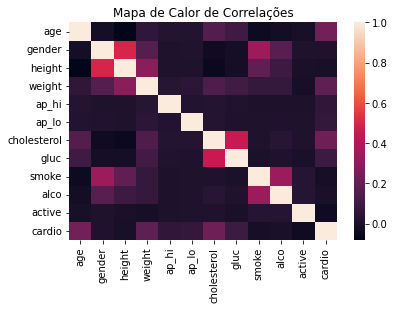

In [14]:
sns.heatmap(df.drop(features_remover, axis=1).corr())
plt.title('Mapa de Calor de Correlações');

1. moderada entre altura e gênero
2. moderada entre colesterol e glicemia
3. moderada entre consumidores de alcool e fumantes
4. moderada entre fumantes e idade
5. várias correlações fracas

In [15]:
df[features_numéricas].describe()

,age_,height,weight,ap_hi,ap_lo
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,52.840671,164.359229,74.205690,128.817286,96.630414
std,6.766774,8.210126,14.395757,154.011419,188.472530
min,29.000000,55.000000,10.000000,-150.000000,-70.000000
25%,48.000000,159.000000,65.000000,120.000000,80.000000
50%,53.000000,165.000000,72.000000,120.000000,80.000000
75%,58.000000,170.000000,82.000000,140.000000,90.000000
max,64.000000,250.000000,200.000000,16020.000000,11000.000000


1. Nada discrepante em idade
2. Pessoas com alturas desde 55 centímetros até 2 metros e meio, aparentemente com discrepancias
3. Pessoas com 10kgs (discrepante uma vez que a idade mínima é 29 anos)
4. Máxima da pressão com número negativo em mínimo e 16020 em máximo (possivel erro de escala)
5. Mínima da pressão com número negativo em mínimo e 11000 em máximo (provável erro de escala)

##### 2.3.5 Individual Numerical Feature Analysis

###### height

In [16]:
outliers_indices, li, ls = buscar_outliers(df, 'height')

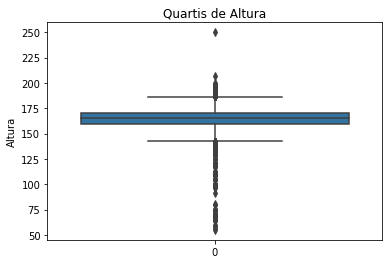

In [17]:
sns.boxplot(data=df['height'])
plt.title('Quartis de Altura')
plt.ylabel('Altura');

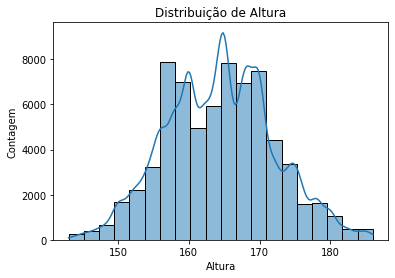

In [18]:
sns.histplot(df.drop(outliers_indices)['height'], bins=20, kde=True)
plt.title('Distribuição de Altura')
plt.xlabel('Altura')
plt.ylabel('Contagem');

Aparentemente há duas modas, e o gerador provavelmente é o gênero

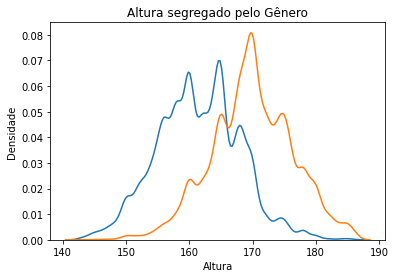

In [19]:
sns.kdeplot(df.drop(outliers_indices).loc[df['gender']==1, 'height'])
sns.kdeplot(df.drop(outliers_indices).loc[df['gender']==2, 'height'])
plt.title('Altura segregado pelo Gênero')
plt.xlabel('Altura')
plt.ylabel('Densidade');

In [20]:
desc_stats(df, 'height')

Dados da feature: height

Máximo (max): 250
Mínimo (min): 55
Range (range): 195
Média (mean): 164.35922857142856
Mediana (median): 165.0
Desvio padrão (standard deviation): 8.210126364538038
Curtose (kurtosis): 7.943652579423719
Assimetria (skew): -0.6421874521557643


###### weight

In [21]:
outliers_indices, li, ls = buscar_outliers(df, 'weight')

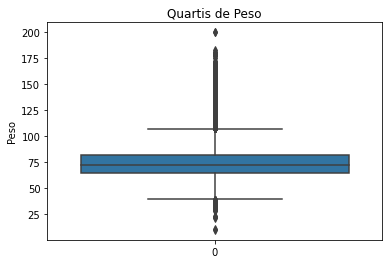

In [22]:
sns.boxplot(data=df['weight'])
plt.title('Quartis de Peso')
plt.ylabel('Peso');

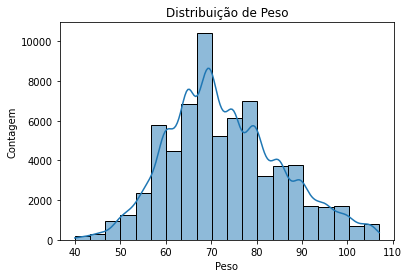

In [23]:
sns.histplot(df.drop(outliers_indices)['weight'], bins=20, kde=True)
plt.title('Distribuição de Peso')
plt.xlabel('Peso')
plt.ylabel('Contagem');

In [24]:
desc_stats(df, 'weight')

Dados da feature: weight

Máximo (max): 200.0
Mínimo (min): 10.0
Range (range): 190.0
Média (mean): 74.20569
Mediana (median): 72.0
Desvio padrão (standard deviation): 14.39575667851138
Curtose (kurtosis): 2.5868254500056223
Assimetria (skew): 1.0120701082089065


###### age

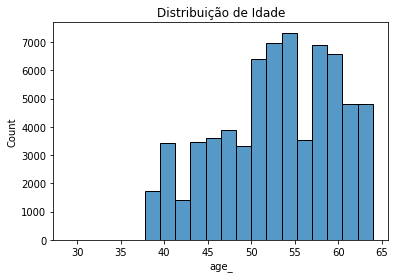

In [25]:
sns.histplot(df.drop(outliers_indices)['age_'], bins=20)
plt.title('Distribuição de Idade');

In [26]:
desc_stats(df, 'age_')

Dados da feature: age_

Máximo (max): 64
Mínimo (min): 29
Range (range): 35
Média (mean): 52.840671428571426
Mediana (median): 53.0
Desvio padrão (standard deviation): 6.766773653742167
Curtose (kurtosis): -0.8189809196744138
Assimetria (skew): -0.30574389867589913


###### ap_hi

In [27]:
outliers_indices, li, ls = buscar_outliers(df, 'ap_hi')

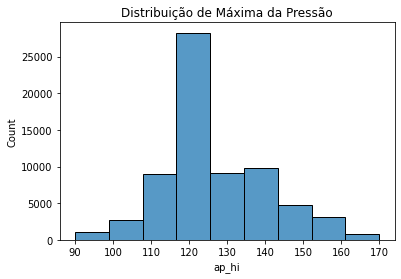

In [28]:
sns.histplot(df.drop(outliers_indices)['ap_hi'], bins=9)
plt.title('Distribuição de Máxima da Pressão');

In [29]:
df['ap_hi'].mean()

128.8172857142857

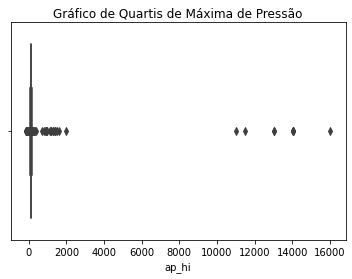

In [30]:
sns.boxplot(x='ap_hi', data=df)
plt.title('Gráfico de Quartis de Máxima de Pressão');

Há uma população entre 10000 e 16000 bastante distante do quarto quartil, e distante também dos outros outliers. Possivelmente sejam erros de escala no imput, parecem ser 100 vezes maiores do que os valores "normais"

In [31]:
df['ap_hi'].describe()

count    70000.000000
mean       128.817286
std        154.011419
min       -150.000000
25%        120.000000
50%        120.000000
75%        140.000000
max      16020.000000
Name: ap_hi, dtype: float64

Valores negativos

In [32]:
df.loc[df['ap_hi']<0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_
4607,6525,15281,1,165,78.0,-100,80,2,1,0,0,1,0,41
16021,22881,22108,2,161,90.0,-115,70,1,1,0,0,1,0,60
20536,29313,15581,1,153,54.0,-100,70,1,1,0,0,1,0,42
23988,34295,18301,1,162,74.0,-140,90,1,1,0,0,1,1,50
25240,36025,14711,2,168,50.0,-120,80,2,1,0,0,0,1,40
35040,50055,23325,2,168,59.0,-150,80,1,1,0,0,1,1,63
46627,66571,23646,2,160,59.0,-120,80,1,1,0,0,0,0,64


Todos os valores parecem condizer com medições de máximas de pressão, caso fossem positivos

In [33]:
desc_stats(df, 'ap_hi')

Dados da feature: ap_hi

Máximo (max): 16020
Mínimo (min): -150
Range (range): 16170
Média (mean): 128.8172857142857
Mediana (median): 120.0
Desvio padrão (standard deviation): 154.01141945609137
Curtose (kurtosis): 7580.07473772039
Assimetria (skew): 85.29621385553034


###### ap_lo

In [34]:
outliers_indices, li, ls = buscar_outliers(df, 'ap_lo')

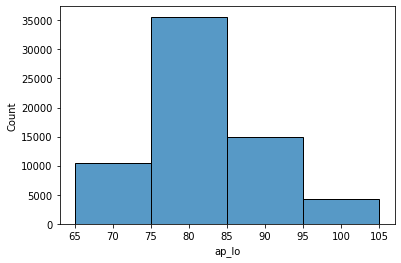

In [35]:
sns.histplot(data=df.drop(outliers_indices), x='ap_lo', bins=4);

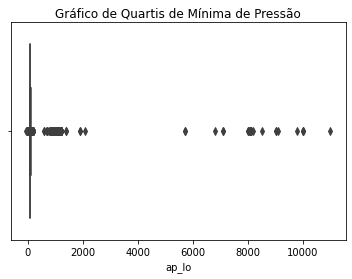

In [36]:
sns.boxplot(x='ap_lo', data=df)
plt.title('Gráfico de Quartis de Mínima de Pressão');

Do mesmo modo que a ap_hi, há uma população de outliers com valores compatíveis com os valores comuns, mas com um tipo de erro de escala. Os valores são 100 vezes maiores. Um teste pode demonstrar se tais outliers são os mesmos outliers que estão presentes em ap_hi em tais características de erro de escala

In [37]:
df.loc[df['ap_lo']>4000, 'id'].count()

24

In [38]:
desc_stats(df, 'ap_lo')

Dados da feature: ap_lo

Máximo (max): 11000
Mínimo (min): -70
Range (range): 11070
Média (mean): 96.63041428571428
Mediana (median): 80.0
Desvio padrão (standard deviation): 188.47253029639026
Curtose (kurtosis): 1425.9145849479457
Assimetria (skew): 32.114082834816884


##### 2.3.6 Bivariate Analytics with Target

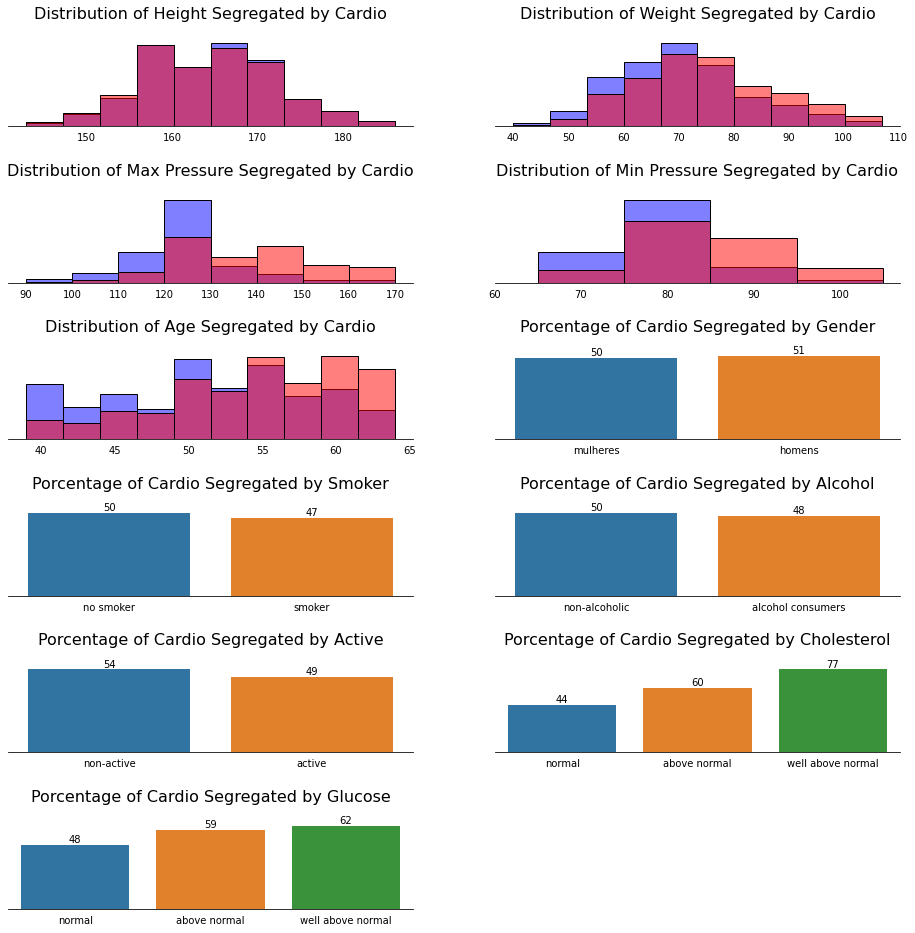

In [39]:
plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace = 0.8)
plt.subplot(6, 2, 1)
indices_outliers, li, ls = buscar_outliers(df, 'height')
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==0], x='height', bins=10, color='b', alpha=0.5)
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==1], x='height', bins=10, color='r', alpha=0.5)
plt.title('Distribution of Height Segregated by Cardio', fontsize=16, pad=20)
ax.tick_params(bottom=False, labelleft=False, left=False)
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)

plt.subplot(6, 2, 2)
indices_outliers, li, ls = buscar_outliers(df, 'weight')
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==0], x='weight', bins=10, color='b', alpha=0.5)
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==1], x='weight', bins=10, color='r', alpha=0.5)
plt.title('Distribution of Weight Segregated by Cardio', fontsize=16, pad=20)
ax.tick_params(bottom=False, labelleft=False, left=False)
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)

plt.subplot(6, 2, 3)
indices_outliers, li, ls = buscar_outliers(df, 'ap_hi')
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==0], x='ap_hi', bins=8, color='b', alpha=0.5)
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==1], x='ap_hi', bins=8, color='r', alpha=0.5)
plt.title('Distribution of Max Pressure Segregated by Cardio', fontsize=16, pad=20)
ax.tick_params(bottom=False, labelleft=False, left=False)
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)

plt.subplot(6, 2, 4)
indices_outliers, li, ls = buscar_outliers(df, 'ap_lo')
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==0], x='ap_lo', bins=4, color='b', alpha=0.5)
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==1], x='ap_lo', bins=4, color='r', alpha=0.5)
plt.xticks(range(60, 110, 10))
plt.title('Distribution of Min Pressure Segregated by Cardio', fontsize=16, pad=20)
ax.tick_params(bottom=False, labelleft=False, left=False)
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)

plt.subplot(6, 2, 5)
indices_outliers, li, ls = buscar_outliers(df, 'age')
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==0], x='age_', bins=10, color='b', alpha=0.5)
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==1], x='age_', bins=10, color='r', alpha=0.5)
plt.title('Distribution of Age Segregated by Cardio', fontsize=16, pad=20)
ax.tick_params(bottom=False, labelleft=False, left=False)
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)

plt.subplot(6, 2, 6)
temp = df.groupby('gender')['cardio'].value_counts(normalize=True).rename('values').reset_index()
temp = round(temp.loc[temp['cardio']==1], 2)*100
ax = sns.barplot(data=temp, x='gender', y='values', ci=None)
ax.tick_params(bottom=False, labelleft=False, left=False)
ax.set_xticklabels(['mulheres', 'homens'])
ax.bar_label(ax.containers[0])
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)
plt.title('Porcentage of Cardio Segregated by Gender', fontsize=16, pad=20)

plt.subplot(6, 2, 7)
temp = df.groupby('smoke')['cardio'].value_counts(normalize=True).rename('values').reset_index()
temp = round(temp.loc[temp['cardio']==1], 2)*100
ax = sns.barplot(data=temp, x='smoke', y='values', ci=None)
ax.tick_params(bottom=False, labelleft=False, left=False)
ax.set_xticklabels(['no smoker', 'smoker'])
ax.bar_label(ax.containers[0])
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)
plt.title('Porcentage of Cardio Segregated by Smoker', fontsize=16, pad=20)

plt.subplot(6, 2, 8)
temp = df.groupby('alco')['cardio'].value_counts(normalize=True).rename('values').reset_index()
temp = round(temp.loc[temp['cardio']==1], 2)*100
ax = sns.barplot(data=temp, x='alco', y='values', ci=None)
ax.tick_params(bottom=False, labelleft=False, left=False)
ax.set_xticklabels(['non-alcoholic', 'alcohol consumers'])
ax.bar_label(ax.containers[0])
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)
plt.title('Porcentage of Cardio Segregated by Alcohol', fontsize=16, pad=20)

plt.subplot(6, 2, 9)
temp = df.groupby('active')['cardio'].value_counts(normalize=True).rename('values').reset_index()
temp = round(temp.loc[temp['cardio']==1], 2)*100
ax = sns.barplot(data=temp, x='active', y='values', ci=None)
ax.tick_params(bottom=False, labelleft=False, left=False)
ax.set_xticklabels(['non-active', 'active'])
ax.bar_label(ax.containers[0])
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)
plt.title('Porcentage of Cardio Segregated by Active', fontsize=16, pad=20)

plt.subplot(6, 2, 10)
temp = df.groupby('cholesterol')['cardio'].value_counts(normalize=True).rename('values').reset_index()
temp = round(temp.loc[temp['cardio']==1], 2)*100
ax = sns.barplot(data=temp, x='cholesterol', y='values', ci=None)
ax.tick_params(bottom=False, labelleft=False, left=False)
ax.set_xticklabels(['normal', 'above normal', 'well above normal'])
ax.bar_label(ax.containers[0])
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)
plt.title('Porcentage of Cardio Segregated by Cholesterol', fontsize=16, pad=20)

plt.subplot(6, 2, 11)
temp = df.groupby('gluc')['cardio'].value_counts(normalize=True).rename('values').reset_index()
temp = round(temp.loc[temp['cardio']==1], 2)*100
ax = sns.barplot(data=temp, x='gluc', y='values', ci=None)
ax.tick_params(bottom=False, labelleft=False, left=False)
ax.set_xticklabels(['normal', 'above normal', 'well above normal'])
ax.bar_label(ax.containers[0])
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)
plt.title('Porcentage of Cardio Segregated by Glucose', fontsize=16, pad=20);

Destacam-se as features: 
1. ap_hi 
2. ap_lo
3. wheight
4. age
5. cholesterol
6. gluc

## 2.4 Data Cleaning

##### 2.4.1 Tratando Outliers

In [40]:
df_backup = df.copy()

In [41]:
df = df_backup.copy()

###### ap_hi

Quanto aos valores negativos

In [42]:
hi_outliers_indices_antes, li, ls = buscar_outliers(df, 'ap_hi')

In [43]:
df.loc[df['ap_hi']<0, 'ap_hi'] = df.loc[df['ap_hi']<0, 'ap_hi'].values * -1

Valores com erros de escala

Em escala de 1 : 1/10

In [44]:
outliers_indices, li, ls = buscar_outliers(df, 'ap_hi')
ap_hi_li = li
ap_hi_ls = ls

erro_escala_indices = df.loc[(df['ap_hi']>=ap_hi_li/10)&(df['ap_hi']<=ap_hi_ls/10)].index

print(f"Quantidade fora de escala: {df.loc[erro_escala_indices, 'id'].count()}")

df.loc[erro_escala_indices, 'ap_hi'] = df.loc[erro_escala_indices, 'ap_hi'].values * 10

Quantidade fora de escala: 173


Em escala de 1 : 10

In [45]:
outliers_indices, li, ls = buscar_outliers(df, 'ap_hi')
ap_hi_li = li
ap_hi_ls = ls

erro_escala_indices = df.loc[(df['ap_hi']>=ap_hi_li*10)&(df['ap_hi']<=ap_hi_ls*10)].index

print(f"Quantidade fora de escala: {df.loc[erro_escala_indices, 'id'].count()}")

df.loc[erro_escala_indices, 'ap_hi'] = df.loc[erro_escala_indices, 'ap_hi'].values / 10

Quantidade fora de escala: 26


Em escala de 1 : 100

In [46]:
outliers_indices, li, ls = buscar_outliers(df, 'ap_hi')
ap_hi_li = li
ap_hi_ls = ls

erro_escala_indices = df.loc[(df['ap_hi']>=ap_hi_li*100)&(df['ap_hi']<=ap_hi_ls*100)].index

print(f"Quantidade fora de escala: {df.loc[erro_escala_indices, 'id'].count()}")

df.loc[erro_escala_indices, 'ap_hi'] = df.loc[erro_escala_indices, 'ap_hi'].values / 100

Quantidade fora de escala: 9


Em escala de 1 : 1000

In [47]:
outliers_indices, li, ls = buscar_outliers(df, 'ap_hi')
ap_hi_li = li
ap_hi_ls = ls

erro_escala_indices = df.loc[(df['ap_hi']>=ap_hi_li*1000)&(df['ap_hi']<=ap_hi_ls*1000)].index

print(f"Quantidade fora de escala: {df.loc[erro_escala_indices, 'id'].count()}")

df.loc[erro_escala_indices, 'ap_hi'] = df.loc[erro_escala_indices, 'ap_hi'].values / 1000

Quantidade fora de escala: 0


Proporção de outliers tratados

In [48]:
print(f'Quantidade de outliers antes da limpeza: {len(hi_outliers_indices_antes)}')
outliers_indices, li, ls = buscar_outliers(df, 'ap_hi')
print(f'Quantidade de outliers depois da limpeza: {len(outliers_indices)}')
diferença = len(hi_outliers_indices_antes) - len(outliers_indices)
diferença_proporcional = diferença / len(hi_outliers_indices_antes) * 100
print(f'Proporção: {round(diferença_proporcional, 2)}%')

Quantidade de outliers antes da limpeza: 1435
Quantidade de outliers depois da limpeza: 1220
Proporção: 14.98%


###### ap_lo

Quanto aos valores negativos

In [49]:
lo_outliers_indices_antes, li, ls = buscar_outliers(df, 'ap_lo')

In [50]:
df.loc[df['ap_lo']<0, 'ap_lo'] = df.loc[df['ap_lo']<0, 'ap_lo'].values * -1

Quanto aos erros de escala

Em escala de 1 : 1/10

In [51]:
outliers_indices, li, ls = buscar_outliers(df, 'ap_lo')
ap_lo_li = li
ap_lo_ls = ls

erro_escala_indices = df.loc[(df['ap_lo']>=ap_lo_li/10)&(df['ap_lo']<=ap_lo_ls/10)].index

print(f"Quantidade fora de escala: {df.loc[erro_escala_indices, 'id'].count()}")

df.loc[erro_escala_indices, 'ap_lo'] = df.loc[erro_escala_indices, 'ap_lo'].values * 10

Quantidade fora de escala: 12


Em escala de 1 : 10

In [52]:
outliers_indices, li, ls = buscar_outliers(df, 'ap_lo')
ap_lo_li = li
ap_lo_ls = ls

erro_escala_indices = df.loc[(df['ap_lo']>=ap_lo_li*10)&(df['ap_lo']<=ap_lo_ls*10)].index

print(f"Quantidade fora de escala: {df.loc[erro_escala_indices, 'id'].count()}")

df.loc[erro_escala_indices, 'ap_lo'] = df.loc[erro_escala_indices, 'ap_lo'].values / 10

Quantidade fora de escala: 718


Em escala de 1 : 100

In [53]:
outliers_indices, li, ls = buscar_outliers(df, 'ap_lo')
ap_lo_li = li
ap_lo_ls = ls

erro_escala_indices = df.loc[(df['ap_lo']>=ap_lo_li*100)&(df['ap_lo']<=ap_lo_ls*100)].index

print(f"Quantidade fora de escala: {df.loc[erro_escala_indices, 'id'].count()}")

df.loc[erro_escala_indices, 'ap_lo'] = df.loc[erro_escala_indices, 'ap_lo'].values / 100

Quantidade fora de escala: 21


Em escala de 1 : 1000

In [54]:
outliers_indices, li, ls = buscar_outliers(df, 'ap_lo')
ap_lo_li = li
ap_lo_ls = ls

erro_escala_indices = df.loc[(df['ap_lo']>=ap_lo_li*100)&(df['ap_lo']<=ap_lo_ls*100)].index

print(f"Quantidade fora de escala: {df.loc[erro_escala_indices, 'id'].count()}")

df.loc[erro_escala_indices, 'ap_lo'] = df.loc[erro_escala_indices, 'ap_lo'].values / 100

Quantidade fora de escala: 0


Quanto aos valores invertidos

In [55]:
outliers_indices, li, ls = buscar_outliers(df, 'ap_hi')
ap_hi_li = li
ap_hi_ls = ls

outliers_indices, li, ls = buscar_outliers(df, 'ap_lo')
ap_lo_li = li
ap_lo_ls = ls

In [56]:
df.loc[((df['ap_lo']>=ap_hi_li)&(df['ap_lo']<=ap_hi_ls))&((df['ap_hi']>=ap_lo_li)&(df['ap_hi']<=ap_lo_ls))].head(5)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_
636,913,20457,2,169,68.0,70.0,110.0,1,1,0,0,1,0,56
2384,3356,23361,1,154,102.0,90.0,150.0,1,1,0,0,0,1,64
2990,4214,21957,2,182,90.0,80.0,140.0,3,3,0,0,1,1,60
3233,4557,22635,2,170,92.0,105.0,90.0,3,1,0,1,0,1,62
3447,4880,19992,2,180,80.0,80.0,125.0,3,3,1,1,1,1,54


Máxima de pressão e mínima de pressão invertidos

In [57]:
print(f"Total de: {df.loc[((df['ap_lo']>=ap_hi_li)&(df['ap_lo']<=ap_hi_ls))&((df['ap_hi']>=ap_lo_li)&(df['ap_hi']<=ap_lo_ls)), 'id'].count()} amostras")

Total de: 147 amostras


In [58]:
invertidos_indices = df.loc[((df['ap_lo']>=ap_hi_li)&(df['ap_lo']<=ap_hi_ls))&((df['ap_hi']>=ap_lo_li)&(df['ap_hi']<=ap_lo_ls))].index

ap_lo = df.loc[invertidos_indices, 'ap_hi']
ap_hi = df.loc[invertidos_indices, 'ap_lo']

df.loc[invertidos_indices, 'ap_lo'] = ap_lo
df.loc[invertidos_indices, 'ap_hi'] = ap_hi

Proporção de outliers tratados

In [59]:
print(f'Quantidade de outliers antes da limpeza: {len(lo_outliers_indices_antes)}')
outliers_indices, li, ls = buscar_outliers(df, 'ap_lo')
print(f'Quantidade de outliers depois da limpeza: {len(outliers_indices)}')
diferença = len(lo_outliers_indices_antes) - len(outliers_indices)
diferença_proporcional = diferença / len(lo_outliers_indices_antes) * 100
print(f'Proporção: {round(diferença_proporcional, 2)}%')

Quantidade de outliers antes da limpeza: 4632
Quantidade de outliers depois da limpeza: 3792
Proporção: 18.13%


Repassando ap_hi após a inversão

In [60]:
print(f'Quantidade de outliers antes da limpeza: {len(hi_outliers_indices_antes)}')
outliers_indices, li, ls = buscar_outliers(df, 'ap_hi')
print(f'Quantidade de outliers depois da limpeza: {len(outliers_indices)}')
diferença = len(hi_outliers_indices_antes) - len(outliers_indices)
diferença_proporcional = diferença / len(hi_outliers_indices_antes) * 100
print(f'Proporção: {round(diferença_proporcional, 2)}%')

Quantidade de outliers antes da limpeza: 1435
Quantidade de outliers depois da limpeza: 1163
Proporção: 18.95%


###### weight

In [61]:
outliers_antes, li, ls = buscar_outliers(df, 'weight')

Como mulheres e homens possuem pesos relativamente diferentes, utilizaremos limites de outliers diferentes por gênero.

In [62]:
_, weight_li_woman, weight_ls_woman = buscar_outliers(df.loc[df['gender']==1], 'weight')
_, weight_li_man, weight_ls_man = buscar_outliers(df.loc[df['gender']==2], 'weight')
outliers_indices = df[(df['weight']<weight_li_woman)|(df['weight']>weight_ls_woman)&(df['gender']==1)].index
outliers_indices.append(df[(df['weight']<weight_li_man)|(df['weight']>weight_ls_man)&(df['gender']==2)].index)
print(len(outliers_indices))

li = weight_li = weight_li_woman
ls = weight_ls = weight_ls_man

1157


In [63]:
df[df['weight']<0]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,age_


Não há negativos

<AxesSubplot:xlabel='weight', ylabel='Count'>

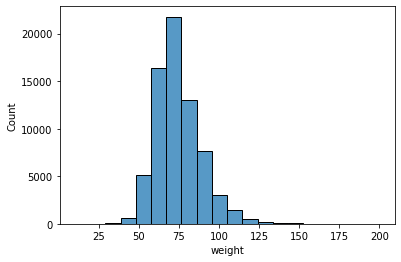

In [64]:
sns.histplot(data=df, x='weight', bins=20)

In [65]:
print(f"Quantidade com erro de escala: {df.loc[(df['weight']>=li / 10)*(df['weight']<=ls / 10), 'id'].count()}")
df.loc[(df['weight']>=li / 10)*(df['weight']<=ls / 10), 'weight'] = df.loc[(df['weight']>=li / 10)*(df['weight']<=ls / 10), 'weight'].values * 10

Quantidade com erro de escala: 2


Invertidos weight e height

In [66]:
height_indices_outliers, height_li, height_ls = buscar_outliers(df, 'height')

indices_invertidos = df.loc[(df['weight']>=height_li)&(df['weight']<=height_ls)&(df['height']>=weight_li)&(df['height']<=weight_ls)].index
weight = df.loc[indices_invertidos, 'height'].values
height = df.loc[indices_invertidos, 'weight'].values

df.loc[indices_invertidos, 'height'] = height
df.loc[indices_invertidos, 'weight'] = weight

In [67]:
print(f'Quantidade invertidos: {len(weight)}')

Quantidade invertidos: 6


Proporção de outliers tratados

In [68]:
print(f'Quantidade de outliers antes da limpeza: {len(outliers_antes)}')
_, weight_li_woman, weight_ls_woman = buscar_outliers(df.loc[df['gender']==1], 'weight')
_, weight_li_man, weight_ls_man = buscar_outliers(df.loc[df['gender']==2], 'weight')
outliers_indices = df[(df['weight']<weight_li_woman)|(df['weight']>weight_ls_woman)&(df['gender']==1)].index
outliers_indices.append(df[(df['weight']<weight_li_man)|(df['weight']>weight_ls_man)&(df['gender']==2)].index)
                        
print(f'Quantidade de outliers depois da limpeza: {len(outliers_indices)}')
diferença = len(outliers_antes) - len(outliers_indices)
diferença_proporcional = diferença / len(outliers_antes) * 100
print(f'Proporção: {round(diferença_proporcional, 2)}%')

Quantidade de outliers antes da limpeza: 1819
Quantidade de outliers depois da limpeza: 1150
Proporção: 36.78%


###### height

In [69]:
outliers_antes, li, ls = buscar_outliers(df, 'height')
len(outliers_antes)

513

Como mulheres e homens possuem pesos relativamente diferentes, utilizaremos limites de outliers diferentes por gênero.

In [70]:
_, height_li_woman, height_ls_woman = buscar_outliers(df.loc[df['gender']==1], 'height')
_, height_li_man, height_ls_man = buscar_outliers(df.loc[df['gender']==2], 'height')
outliers_indices = df[(df['height']<height_li_woman)|(df['height']>height_ls_woman)&(df['gender']==1)].index
outliers_indices.append(df[(df['height']<height_li_man)|(df['height']>height_ls_man)&(df['gender']==2)].index)
print(len(outliers_indices))

li = height_li = height_li_woman
ls = height_ls = height_ls_man

548


###### age

###### 2.4.2 Removendo Outliers

In [71]:
df_backup = df.copy()

In [72]:
df = df_backup.copy()

In [73]:
qtd_antes = df.shape[0]
print('Estudos sobre Outliers\n')
outliers_indices, li, ls = buscar_outliers(df, 'age_')
print('Age')
print(f'Quantidade total de amostras outliers: {df.loc[outliers_indices, "id"].count()}')
print(f'Proporção em relação ao dataset: {round(len(outliers_indices)/qtd_antes*100, 2)} %')
print(f'Limite inferior: {li} \nLimite superior: {ls}')
print(f'Quantidade de amostas maiores: {df.loc[df["age_"] > ls, "id"].count()}')
print(f'Quantidade de amostas menores: {df.loc[df["age_"] < li, "id"].count()}\n')
df.drop(outliers_indices, inplace=True)

outliers_indices, li, ls = buscar_outliers(df, 'height')
print('Height')
print(f'Quantidade total de amostras outliers: {df.loc[outliers_indices, "id"].count()}')
print(f'Proporção em relação ao dataset: {round(len(outliers_indices)/qtd_antes*100, 2)} %')
print(f'Limite inferior: {li} \nLimite superior: {ls}')
print(f'Quantidade de amostas maiores: {df.loc[df["height"] > ls, "id"].count()}')
print(f'Quantidade de amostas menores: {df.loc[df["height"] < li, "id"].count()}\n')
df.drop(outliers_indices, inplace=True)

_, weight_li_woman, weight_ls_woman = buscar_outliers(df.loc[df['gender']==1], 'weight')
_, weight_li_man, weight_ls_man = buscar_outliers(df.loc[df['gender']==2], 'weight')
outliers_indices = df[(df['weight']<weight_li_woman)|(df['weight']>weight_ls_woman)&(df['gender']==1)].index
outliers_indices.append(df[(df['weight']<weight_li_man)|(df['weight']>weight_ls_man)&(df['gender']==2)].index)
print('Weight')
print(f'Quantidade total de amostras outliers: {df.loc[outliers_indices, "id"].count()}')
print(f'Proporção em relação ao dataset: {round(len(outliers_indices)/qtd_antes*100, 2)} %')
print(f'Quantidade de amostas maiores: {df.loc[df["weight"] > ls, "id"].count()}')
print(f'Quantidade de amostas menores: {df.loc[df["weight"] < li, "id"].count()}\n')
df.drop(outliers_indices, inplace=True)

outliers_indices, li, ls = buscar_outliers(df, 'ap_hi')
print('Ap_hi')
print(f'Quantidade total de amostras outliers: {df.loc[outliers_indices, "id"].count()}')
print(f'Proporção em relação ao dataset: {round(len(outliers_indices)/qtd_antes*100, 2)} %')
print(f'Quantidade de amostas maiores: {df.loc[df["ap_hi"] > ls, "id"].count()}')
print(f'Quantidade de amostas menores: {df.loc[df["ap_hi"] < li, "id"].count()}\n')
df.drop(outliers_indices, inplace=True)

outliers_indices, li, ls = buscar_outliers(df, 'ap_lo')
print('Ap_lo')
print(f'Quantidade total de amostras outliers: {df.loc[outliers_indices, "id"].count()}')
print(f'Proporção em relação ao dataset: {round(len(outliers_indices)/qtd_antes*100, 2)} %')
print(f'Quantidade de amostas maiores: {df.loc[df["ap_lo"] > ls, "id"].count()}')
print(f'Quantidade de amostas menores: {df.loc[df["ap_lo"] < li, "id"].count()}\n')
df.drop(outliers_indices, inplace=True)

qtd_depois = df.shape[0]
outliers_total = qtd_antes - qtd_depois
outliers_total_proporcional = outliers_total / qtd_antes
print('Sobre o total de outliers:')
print(f'Quantidade de amostras antes: {qtd_antes}')
print(f'Quantidade de amostras depois: {qtd_depois}')
print(f'Diferença: {outliers_total}')
print(f'Diferença proporcional: {round(outliers_total_proporcional*100, 2)} %')

Estudos sobre Outliers

Age
Quantidade total de amostras outliers: 4
Proporção em relação ao dataset: 0.01 %
Limite inferior: 33.0 
Limite superior: 73.0
Quantidade de amostas maiores: 0
Quantidade de amostas menores: 4

Height
Quantidade total de amostras outliers: 513
Proporção em relação ao dataset: 0.73 %
Limite inferior: 142.5 
Limite superior: 186.5
Quantidade de amostas maiores: 269
Quantidade de amostas menores: 244

Weight
Quantidade total de amostras outliers: 1133
Proporção em relação ao dataset: 1.62 %
Quantidade de amostas maiores: 2
Quantidade de amostas menores: 69407

Ap_hi
Quantidade total de amostras outliers: 1083
Proporção em relação ao dataset: 1.55 %
Quantidade de amostas maiores: 1001
Quantidade de amostas menores: 82

Ap_lo
Quantidade total de amostras outliers: 3304
Proporção em relação ao dataset: 4.72 %
Quantidade de amostas maiores: 512
Quantidade de amostas menores: 2792

Sobre o total de outliers:
Quantidade de amostras antes: 70000
Quantidade de amostras 

# 3.0 Feature Engineering

In [74]:
df['imc'] = df['weight'] / df['height'] ** 2

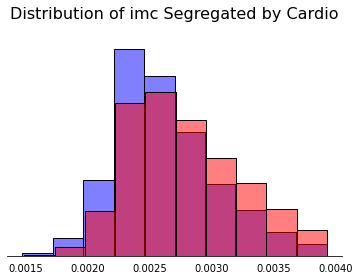

In [75]:
indices_outliers, li, ls = buscar_outliers(df, 'imc')
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==0], x='imc', bins=10, color='b', alpha=0.5)
ax = sns.histplot(data=df.drop(indices_outliers).loc[df['cardio']==1], x='imc', bins=10, color='r', alpha=0.5)
plt.title('Distribution of imc Segregated by Cardio', fontsize=16, pad=20)
ax.tick_params(bottom=False, labelleft=False, left=False)
plt.ylabel('')
plt.xlabel('')
sns.despine(left=True)

# 4.0 Business Hypothesis

# 5.0 Exploratory Data Analysis

# 6.0 Data Preparation

In [76]:
X = df.drop(features_remover+features_target, axis=1)
X = np.array(X)
y = df[features_target]
y = np.array(y).reshape(1, len(y))[0]

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [78]:
scaler = StandardScaler()

scaler = scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 7.0 Machine Learning

###### Model description

In [79]:
rf_model = RandomForestClassifier()

###### Fiting model

In [80]:
rf_fit = rf_model.fit(X_train, y_train)

###### Predicts

In [81]:
rf_predict = rf_fit.predict(X_test)

###### Metrics

In [82]:
print(classification_report(y_test, rf_predict))

              precision    recall  f1-score   support

           0       0.70      0.73      0.71      9656
           1       0.71      0.68      0.70      9533

    accuracy                           0.71     19189
   macro avg       0.71      0.71      0.71     19189
weighted avg       0.71      0.71      0.71     19189



# 8.0 Results and Conclusions

# Time

In [83]:
print(f'O tempo de processamento do projeto foi de: {int(round(time.time()-tempo_agora, 2)/60)} minutos')

O tempo de processamento do projeto foi de: 0 minutos
